# Download Dataset

In [1]:
#Mendownload dataset
!gdown 1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv -O data/dataset.zip

#Melakukan unzip file dataset
!unzip -q data/dataset.zip -d data/

#Menghapus file zip
!rm -rf data/dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv
From (redirected): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv&confirm=t&uuid=c8e0e022-4e32-4e89-9367-4a2557d4a294
To: /workspace/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/data/dataset.zip
100%|████████████████████████████████████████| 864M/864M [00:18<00:00, 45.6MB/s]


# Split Dataset

In [2]:
!python utils/example.py

Pemisahan file gambar berdasarkan class selesai!
split_dataset_utama done
Pemisahan dan penggabungan file gambar dari data/ROOT/train dan data/ROOT/test berdasarkan class selesai!
split_dataset_utama_versi_submission done
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama done
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama_versi_submission done
Class 'Black Rot' telah dibagi ke dalam train, val, dan test.
Class 'Cedar Rust' telah dibagi ke dalam train, val, dan test.
Class 'Healthy' telah dibagi ke dalam train, val, dan test.


# Import Library

In [39]:
# Import library yang digunakan untuk keseluruhan dataset
import os
import random
import shutil
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Import model arsitektur dan preprocess input untuk MobileNet dan EfficientNet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Define Fungsi

In [4]:
# Cek apakah GPU tersedia
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Atur batas memori GPU (dalam byte)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]  # 20GB dalam megabyte
        )
        print(f"Batas VRAM berhasil diatur: {20480 / 1024} GB")
    except RuntimeError as e:
        print(e)

Batas VRAM berhasil diatur: 20.0 GB


In [5]:
# Daftar model EfficientNet yang akan dihitung jumlah layernya
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
]

# List untuk menyimpan hasil jumlah layer
model_layers_count = []

# Loop melalui setiap varian dan hitung jumlah layer
for variant in efficientnet_variants:
    model_name = variant.__name__  # Mendapatkan nama model
    model = variant(weights='imagenet')  # Menggunakan weights 'imagenet'
    layer_count = len(model.layers)  # Menghitung jumlah layer
    model_layers_count.append((model_name, layer_count))  # Menyimpan hasil ke list

# Membuat dataframe dari hasil yang diperoleh
df_layers = pd.DataFrame(model_layers_count, columns=['Model', 'Number of Layers'])

# Menampilkan tabel jumlah layer
print(df_layers)

2024-10-10 15:54:54.061364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


268326632/268326632 [==============================] - 3s 0us/step
            Model  Number of Layers
0  EfficientNetB0               241
1  EfficientNetB1               343
2  EfficientNetB2               343
3  EfficientNetB3               388
4  EfficientNetB4               478
5  EfficientNetB5               580
6  EfficientNetB6               670
7  EfficientNetB7               817


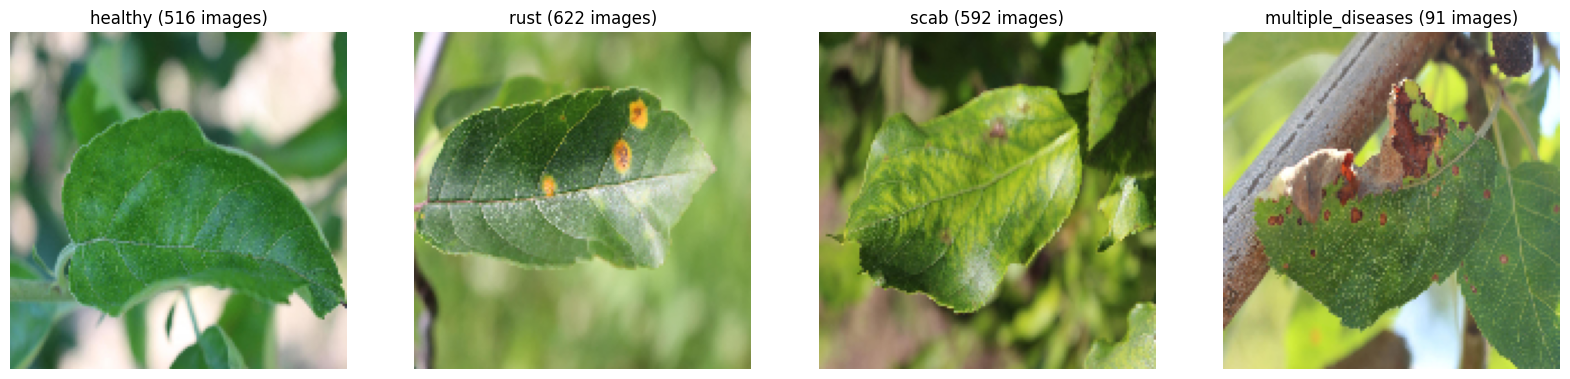

In [6]:
# Path ke folder dataset utama
base_path = 'data/original_dataset_utama/train'

# Daftar kelas yang ingin ditampilkan
classes = ['healthy', 'rust', 'scab', 'multiple_diseases']

# Membuat figure dengan subplot
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

# Iterasi untuk setiap kelas
for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    
    # Menghitung jumlah gambar di setiap kelas
    num_images = len([file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))])
    
    # Memilih gambar sample untuk ditampilkan
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    
    # Memuat dan menampilkan gambar
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    
    # Mengatur judul dengan menambahkan nama kelas dan jumlah gambar
    ax[i].set_title(f"{class_name} ({num_images} images)")

# Menampilkan hasil plot
plt.show()

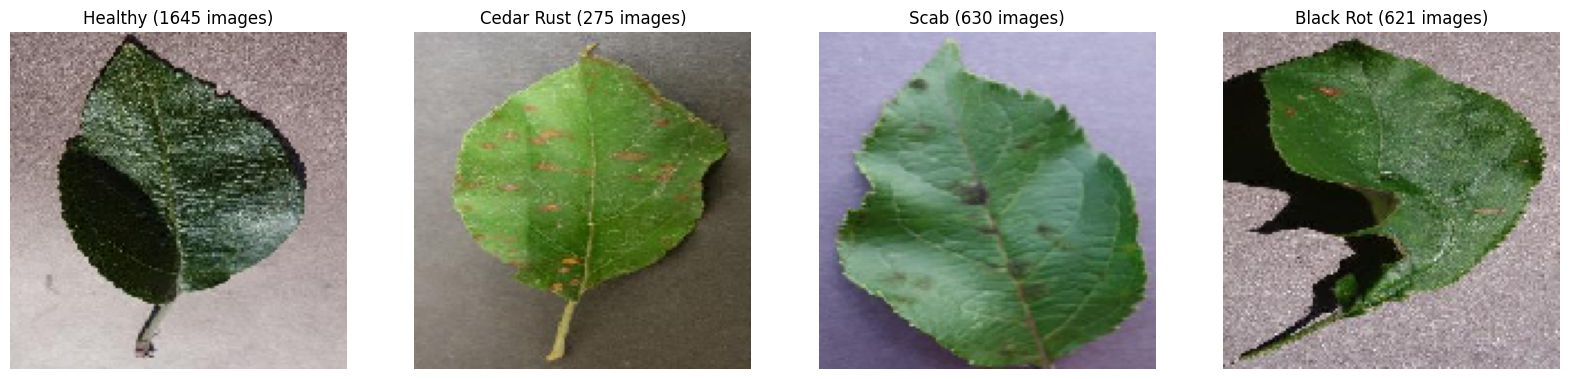

In [7]:
# Path ke folder dataset utama
base_path = 'data/original_dataset_cadangan'

# Daftar kelas yang ingin ditampilkan
classes = ['Healthy', 'Cedar Rust', 'Scab', 'Black Rot']

# Membuat figure dengan subplot
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

# Iterasi untuk setiap kelas
for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    num_images = len([file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))])
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"{class_name} ({num_images} images)")

plt.show()

In [50]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [51]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [52]:
def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 85% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.85 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [53]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs, save_directory):
    # Membuat folder penyimpanan jika belum ada
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Membuat folder untuk menyimpan gambar
    images_save_directory = os.path.join(save_directory, 'images')
    if not os.path.exists(images_save_directory):
        os.makedirs(images_save_directory)

    # Menyusun nama file penyimpanan model dengan parameter model_name
    save_path = os.path.join(save_directory, f'best_model_{model_name}.h5')

    # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
    checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the loss plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_accuracy_loss.png'))

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the confusion matrix plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_confusion_matrix.png'))

    # Tampilkan confusion matrix
    plt.close()
    # plt.show()

    return history, test_loss, test_accuracy, training_duration


In [54]:
# Fungsi untuk menyimpan hasil evaluasi ke dalam dictionary dan menampilkan dalam tabel
def store_results(model_name, history, test_loss, test_accuracy, training_duration, results_dict):
    # Menyimpan nama model
    results_dict['Model'].append(model_name)
    
    # Mengambil akurasi dan loss tertinggi dari history untuk training dan validation
    max_train_acc = max(history.history['accuracy']) if 'accuracy' in history.history else None
    max_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None
    
    results_dict['Train Accuracy'].append(max_train_acc)
    results_dict['Train Loss'].append(min(history.history['loss']) if 'loss' in history.history else None)
    results_dict['Validation Accuracy'].append(max_val_acc)
    results_dict['Validation Loss'].append(min(history.history['val_loss']) if 'val_loss' in history.history else None)

    # Menyimpan training duration
    results_dict['Training Duration'].append(training_duration)
    
    # Menyimpan hasil evaluasi test loss dan test accuracy
    results_dict['Test Accuracy'].append(test_accuracy)
    results_dict['Test Loss'].append(test_loss)
    

    # Menyimpan total epoch
    results_dict['Total Epoch'].append(history.epoch)

# Membuat dictionary untuk menyimpan hasil evaluasi
results_not_trainable = {
    'Model': [],
    'Train Accuracy':[],
    'Train Loss':[],
    'Validation Accuracy':[],
    'Validation Loss':[],
    'Test Loss': [],
    'Test Accuracy': [],
    'Training Duration': [],
    'Total Epoch': []
}

results_trainable = {
    'Model': [],
    'Train Accuracy':[],
    'Train Loss':[],
    'Validation Accuracy':[],
    'Validation Loss':[],
    'Test Loss': [],
    'Test Accuracy': [],
    'Training Duration': [],
    'Total Epoch': []
}

In [55]:
efficientnet_input_shapes = {
    'EfficientNetB0': (224, 224),
    'EfficientNetB1': (240, 240),
    'EfficientNetB2': (260, 260),
    'EfficientNetB3': (300, 300),
    'EfficientNetB4': (380, 380),
    'EfficientNetB5': (456, 456),
    'EfficientNetB6': (528, 528),
    'EfficientNetB7': (600, 600),
}

base_path = "data/split_train_test_dataset_campuran"

preprocess_input_func = efficientnet_preprocess

| Model           | Total Layers | Freeze Layers | Train Layers |
|-----------------|--------------|---------------|--------------|
| EfficientNetB0  | 241          | 204           | 37           |
| EfficientNetB1  | 343          | 291           | 52           |
| EfficientNetB2  | 343          | 291           | 52           |
| EfficientNetB3  | 388          | 329           | 59           |
| EfficientNetB4  | 478          | 406           | 72           |
| EfficientNetB5  | 580          | 493           | 87           |
| EfficientNetB6  | 670          | 569           | 101          |
| EfficientNetB7  | 817          | 694           | 123          |


# Not Trainable

In [56]:
epochs = 50
batch_size = 32
save_directory_not_trainable = 'best_model_not_trainable/'
save_directory_trainable = 'best_model_trainable/'

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.6483

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 27s 504ms/step - loss: 0.7927 - accuracy: 0.6483 - val_loss: 0.6784 - val_accuracy: 0.6494
Epoch 2/50
44/44 [==============================] - 21s 475ms/step - loss: 0.5054 - accuracy: 0.7909 - val_loss: 0.4584 - val_accuracy: 0.7989
Epoch 3/50
44/44 [==============================] - 20s 460ms/step - loss: 0.4426 - accuracy: 0.8227 - val_loss: 0.4791 - val_accuracy: 0.8046
Epoch 4/50
44/44 [==============================] - 20s 463ms/step - loss: 0.3867 - accuracy: 0.8531 - val_loss: 0.3599 - val_accuracy: 0.8678
Epoch 5/50
44/44 [==============================] - 21s 468ms/step - loss: 0.3289 - accuracy: 0.8683 - val_loss: 0.3934 - val_accuracy: 0.8420
Epoch 6/50
44/44 [==============================] - 21s 466ms/step - loss: 0.3118 - accuracy: 0.8849 - val_loss: 0.3185 - val_accuracy: 0.8736
Epoch 7/50
44/44 [==============================] - 21s 469ms/step - loss: 0.3124 - accuracy: 0.8784 - val_loss: 0.3513 - val_accuracy: 0.8592
Epoch 8/50

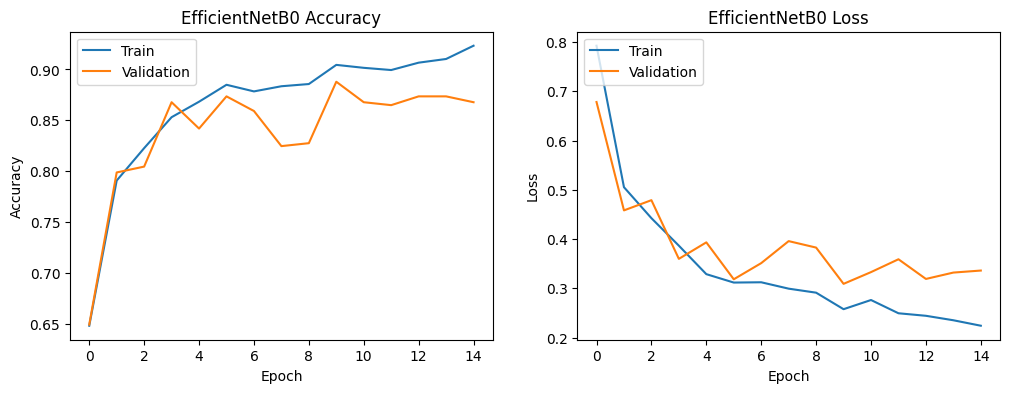

80/80 [==============================] - 2s 26ms/step - loss: 0.9807 - accuracy: 0.7165
Test Accuracy: 0.7165
80/80 [==============================] - 3s 23ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.71      1.00      0.83      1645
        rust       0.79      0.21      0.33       275
        scab       0.71      0.20      0.31       630

    accuracy                           0.72      2550
   macro avg       0.74      0.47      0.49      2550
weighted avg       0.72      0.72      0.65      2550



In [57]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_not_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(EN_B0, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B0, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.6339

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 32s 560ms/step - loss: 0.8173 - accuracy: 0.6339 - val_loss: 0.5705 - val_accuracy: 0.7586
Epoch 2/50
44/44 [==============================] - 23s 515ms/step - loss: 0.5061 - accuracy: 0.8054 - val_loss: 0.3626 - val_accuracy: 0.8448
Epoch 3/50
44/44 [==============================] - 22s 512ms/step - loss: 0.3975 - accuracy: 0.8466 - val_loss: 0.3240 - val_accuracy: 0.8707
Epoch 4/50
44/44 [==============================] - 23s 517ms/step - loss: 0.3805 - accuracy: 0.8538 - val_loss: 0.3178 - val_accuracy: 0.8563
Epoch 5/50
44/44 [==============================] - 21s 486ms/step - loss: 0.3245 - accuracy: 0.8799 - val_loss: 0.4504 - val_accuracy: 0.8247
Epoch 6/50
44/44 [==============================] - 22s 504ms/step - loss: 0.3054 - accuracy: 0.8821 - val_loss: 0.3314 - val_accuracy: 0.8707
Epoch 7/50
44/44 [==============================] - 22s 506ms/step - loss: 0.2971 - accuracy: 0.8849 - val_loss: 0.3101 - val_accuracy: 0.8736
Epoch 8/50

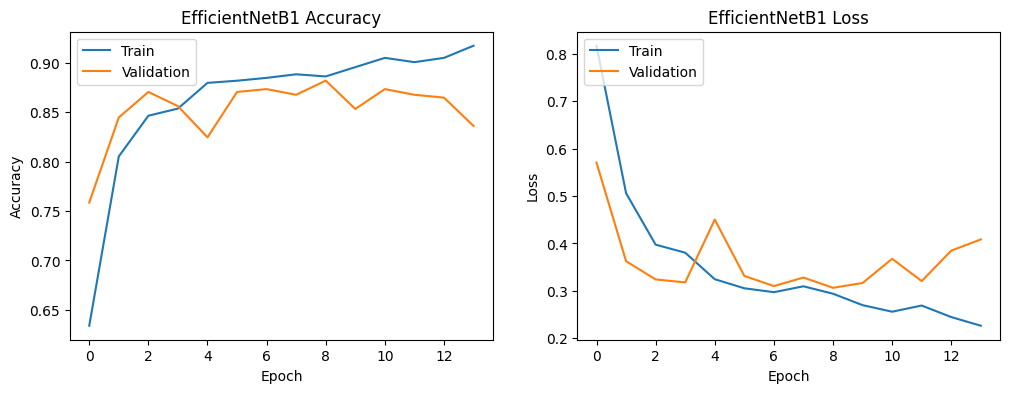

80/80 [==============================] - 3s 36ms/step - loss: 0.6632 - accuracy: 0.7592
Test Accuracy: 0.7592
80/80 [==============================] - 5s 43ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.80      0.98      0.88      1645
        rust       0.64      0.24      0.35       275
        scab       0.61      0.41      0.49       630

    accuracy                           0.76      2550
   macro avg       0.68      0.54      0.57      2550
weighted avg       0.73      0.76      0.73      2550



In [58]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_not_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1, test_loss, test_acc, training_duration = train_and_plot(EN_B1, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B1, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6339

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 31s 578ms/step - loss: 0.8296 - accuracy: 0.6339 - val_loss: 0.4683 - val_accuracy: 0.8017
Epoch 2/50
44/44 [==============================] - 23s 530ms/step - loss: 0.4905 - accuracy: 0.8133 - val_loss: 0.3413 - val_accuracy: 0.8534
Epoch 3/50
44/44 [==============================] - 23s 525ms/step - loss: 0.4225 - accuracy: 0.8444 - val_loss: 0.3810 - val_accuracy: 0.8362
Epoch 4/50
44/44 [==============================] - 24s 537ms/step - loss: 0.3647 - accuracy: 0.8654 - val_loss: 0.3116 - val_accuracy: 0.8592
Epoch 5/50
44/44 [==============================] - 25s 559ms/step - loss: 0.3481 - accuracy: 0.8676 - val_loss: 0.2722 - val_accuracy: 0.8908
Epoch 6/50
44/44 [==============================] - 23s 520ms/step - loss: 0.2989 - accuracy: 0.8922 - val_loss: 0.2912 - val_accuracy: 0.8793
Epoch 7/50
44/44 [==============================] - 23s 521ms/step - loss: 0.2843 - accuracy: 0.8878 - val_loss: 0.3238 - val_accuracy: 0.8736
Epoch 8/50

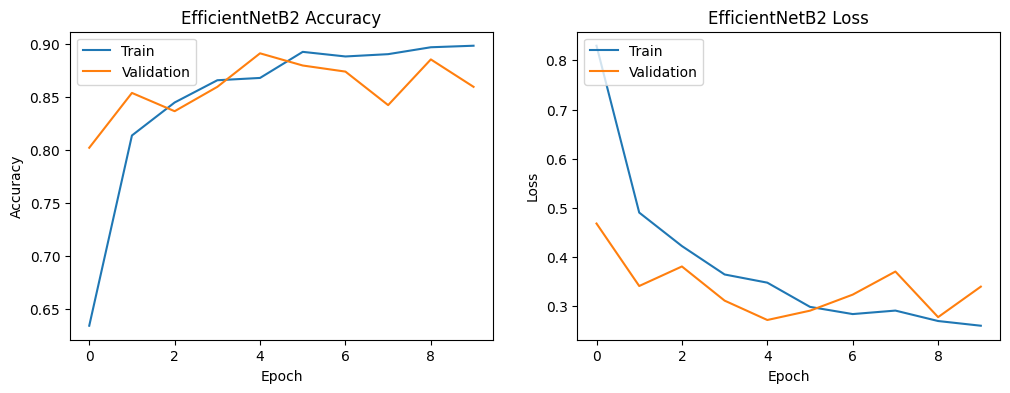

80/80 [==============================] - 3s 32ms/step - loss: 0.6652 - accuracy: 0.7459
Test Accuracy: 0.7459
80/80 [==============================] - 4s 32ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.83      0.92      0.87      1645
        rust       0.72      0.24      0.36       275
        scab       0.52      0.52      0.52       630

    accuracy                           0.75      2550
   macro avg       0.69      0.56      0.58      2550
weighted avg       0.74      0.75      0.73      2550



In [59]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_not_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2, test_loss, test_acc, training_duration = train_and_plot(EN_B2, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B2, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.6700

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 38s 714ms/step - loss: 0.7364 - accuracy: 0.6700 - val_loss: 0.3813 - val_accuracy: 0.8736
Epoch 2/50
44/44 [==============================] - 29s 666ms/step - loss: 0.4376 - accuracy: 0.8285 - val_loss: 0.4083 - val_accuracy: 0.8362
Epoch 3/50
44/44 [==============================] - 30s 684ms/step - loss: 0.3530 - accuracy: 0.8640 - val_loss: 0.2877 - val_accuracy: 0.8822
Epoch 4/50
44/44 [==============================] - 28s 638ms/step - loss: 0.3316 - accuracy: 0.8734 - val_loss: 0.2866 - val_accuracy: 0.8793
Epoch 5/50
44/44 [==============================] - 29s 658ms/step - loss: 0.3081 - accuracy: 0.8806 - val_loss: 0.3095 - val_accuracy: 0.8793
Epoch 6/50
44/44 [==============================] - 29s 665ms/step - loss: 0.3060 - accuracy: 0.8799 - val_loss: 0.3395 - val_accuracy: 0.8649
Epoch 7/50
44/44 [==============================] - 31s 702ms/step - loss: 0.2649 - accuracy: 0.9001 - val_loss: 0.2686 - val_accuracy: 0.8994
Epoch 8/50

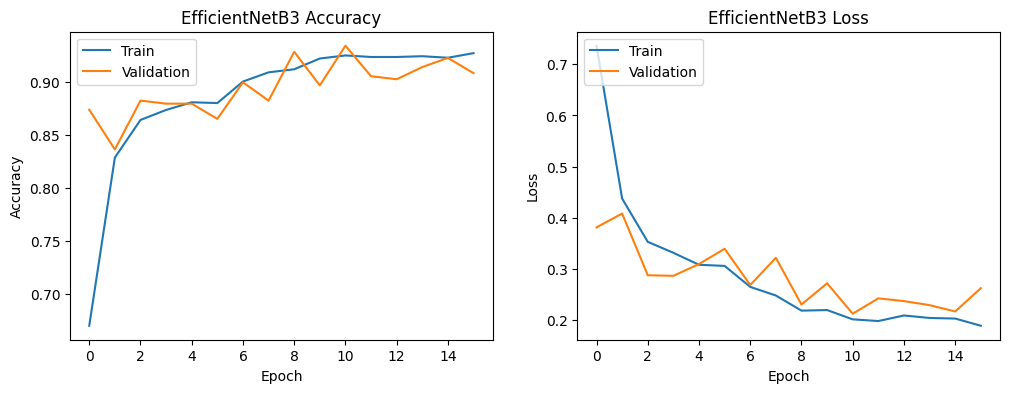

80/80 [==============================] - 7s 83ms/step - loss: 0.6092 - accuracy: 0.7761
Test Accuracy: 0.7761
80/80 [==============================] - 9s 90ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.92      0.84      0.88      1645
        rust       0.69      0.37      0.48       275
        scab       0.54      0.77      0.64       630

    accuracy                           0.78      2550
   macro avg       0.72      0.66      0.67      2550
weighted avg       0.80      0.78      0.78      2550



In [60]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_not_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3, test_loss, test_acc, training_duration = train_and_plot(EN_B3, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B3, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.6505

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 52s 985ms/step - loss: 0.7770 - accuracy: 0.6505 - val_loss: 0.3845 - val_accuracy: 0.8477
Epoch 2/50
44/44 [==============================] - 42s 957ms/step - loss: 0.4052 - accuracy: 0.8386 - val_loss: 0.2635 - val_accuracy: 0.9080
Epoch 3/50
44/44 [==============================] - 41s 925ms/step - loss: 0.3426 - accuracy: 0.8661 - val_loss: 0.2494 - val_accuracy: 0.9080
Epoch 4/50
44/44 [==============================] - 44s 1s/step - loss: 0.2760 - accuracy: 0.8922 - val_loss: 0.2029 - val_accuracy: 0.9195
Epoch 5/50
44/44 [==============================] - 42s 952ms/step - loss: 0.2357 - accuracy: 0.9081 - val_loss: 0.1827 - val_accuracy: 0.9282
Epoch 6/50
44/44 [==============================] - 44s 999ms/step - loss: 0.2543 - accuracy: 0.9088 - val_loss: 0.1837 - val_accuracy: 0.9310
Epoch 7/50
44/44 [==============================] - 43s 982ms/step - loss: 0.1812 - accuracy: 0.9378 - val_loss: 0.1958 - val_accuracy: 0.9282
Epoch 8/50
44

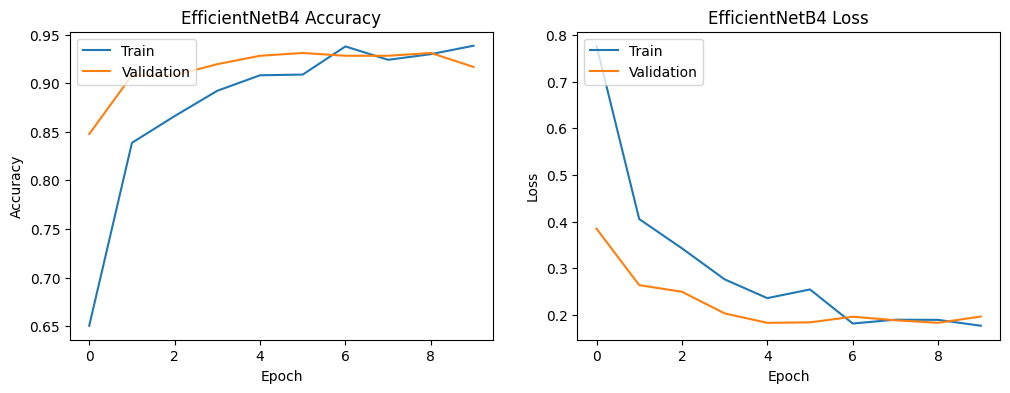

80/80 [==============================] - 10s 128ms/step - loss: 0.7975 - accuracy: 0.7325
Test Accuracy: 0.7325
80/80 [==============================] - 13s 131ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.92      0.82      0.86      1645
        rust       0.64      0.06      0.11       275
        scab       0.48      0.80      0.60       630

    accuracy                           0.73      2550
   macro avg       0.68      0.56      0.52      2550
weighted avg       0.78      0.73      0.72      2550



In [61]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_not_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4, test_loss, test_acc, training_duration = train_and_plot(EN_B4, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B4, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
115263384/115263384 [==============================] - 1s 0us/step
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.6476

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 66s 1s/step - loss: 0.7572 - accuracy: 0.6476 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 2/50
44/44 [==============================] - 56s 1s/step - loss: 0.3893 - accuracy: 0.8524 - val_loss: 0.3293 - val_accuracy: 0.8678
Epoch 3/50
44/44 [==============================] - 55s 1s/step - loss: 0.3291 - accuracy: 0.8806 - val_loss: 0.2596 - val_accuracy: 0.8908
Epoch 4/50
44/44 [==============================] - 53s 1s/step - loss: 0.2370 - accuracy: 0.9117 - val_loss: 0.2661 - val_accuracy: 0.8879
Epoch 5/50
44/44 [==============================] - 53s 1s/step - loss: 0.2102 - accuracy: 0.9298 - val_loss: 0.3235 - val_accuracy: 0.8707
Epoch 6/50
44/44 [==============================] - 53s 1s/step - loss: 0.2047 - accuracy: 0.9262 - val_loss: 0.2308 - val_accuracy: 0.8966
Epoch 7/50
44/44 [==============================] - 54s 1s/step - loss: 0.1944 - accuracy: 0.9305 - val_loss: 0.2610 - val_accuracy: 0.9023
Epoch 8/50
44/44 [=============

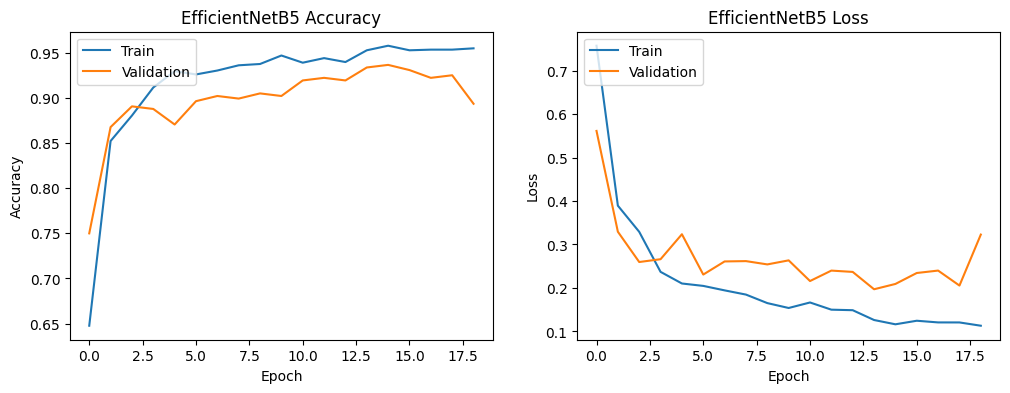

80/80 [==============================] - 15s 185ms/step - loss: 0.6221 - accuracy: 0.7976
Test Accuracy: 0.7976
80/80 [==============================] - 17s 186ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      0.97      0.91      1645
        rust       0.67      0.27      0.39       275
        scab       0.63      0.57      0.60       630

    accuracy                           0.80      2550
   macro avg       0.72      0.60      0.63      2550
weighted avg       0.78      0.80      0.78      2550



In [62]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_not_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5, test_loss, test_acc, training_duration = train_and_plot(EN_B5, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B5, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
165234480/165234480 [==============================] - 3s 0us/step
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.6491

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 82s 2s/step - loss: 0.7942 - accuracy: 0.6491 - val_loss: 0.4726 - val_accuracy: 0.8132
Epoch 2/50
44/44 [==============================] - 68s 2s/step - loss: 0.4018 - accuracy: 0.8517 - val_loss: 0.3003 - val_accuracy: 0.8879
Epoch 3/50
44/44 [==============================] - 69s 2s/step - loss: 0.3098 - accuracy: 0.8835 - val_loss: 0.2433 - val_accuracy: 0.8994
Epoch 4/50
44/44 [==============================] - 68s 2s/step - loss: 0.2574 - accuracy: 0.9088 - val_loss: 0.2333 - val_accuracy: 0.9080
Epoch 5/50
44/44 [==============================] - 71s 2s/step - loss: 0.2513 - accuracy: 0.9081 - val_loss: 0.2264 - val_accuracy: 0.9167
Epoch 6/50
44/44 [==============================] - 68s 2s/step - loss: 0.2015 - accuracy: 0.9219 - val_loss: 0.2022 - val_accuracy: 0.9224
Epoch 7/50
44/44 [==============================] - 66s 2s/step - loss: 0.1894 - accuracy: 0.9342 - val_loss: 0.2216 - val_accuracy: 0.9195
Epoch 8/50
44/44 [=============

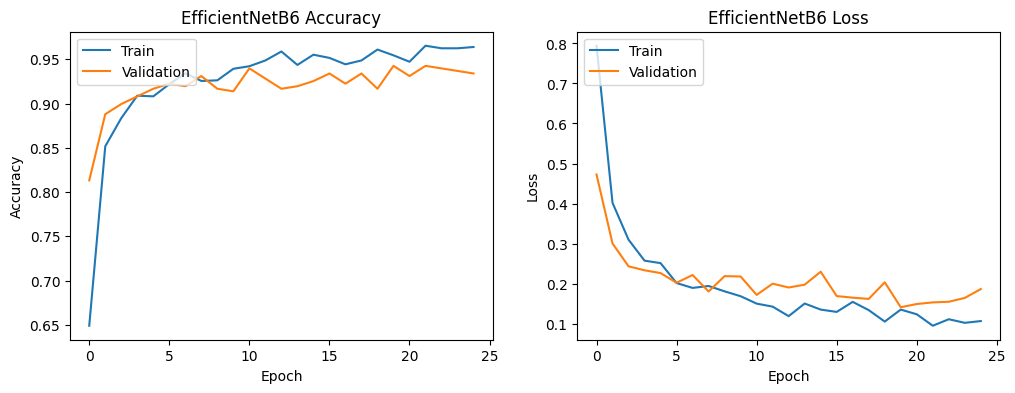

80/80 [==============================] - 24s 298ms/step - loss: 1.0362 - accuracy: 0.7541
Test Accuracy: 0.7541
80/80 [==============================] - 27s 298ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.90      0.87      0.89      1645
        rust       0.45      0.04      0.07       275
        scab       0.51      0.76      0.61       630

    accuracy                           0.75      2550
   macro avg       0.62      0.56      0.52      2550
weighted avg       0.76      0.75      0.73      2550



In [63]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_not_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6, test_loss, test_acc, training_duration = train_and_plot(EN_B6, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B6, test_loss, test_acc, training_duration, results_not_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
258076736/258076736 [==============================] - 3s 0us/step
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.6237

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 103s 2s/step - loss: 0.8442 - accuracy: 0.6237 - val_loss: 0.5133 - val_accuracy: 0.8103
Epoch 2/50
44/44 [==============================] - 86s 2s/step - loss: 0.4694 - accuracy: 0.8162 - val_loss: 0.3850 - val_accuracy: 0.8592
Epoch 3/50
44/44 [==============================] - 84s 2s/step - loss: 0.3401 - accuracy: 0.8755 - val_loss: 0.3376 - val_accuracy: 0.8707
Epoch 4/50
44/44 [==============================] - 86s 2s/step - loss: 0.2747 - accuracy: 0.9023 - val_loss: 0.2683 - val_accuracy: 0.9023
Epoch 5/50
44/44 [==============================] - 87s 2s/step - loss: 0.2409 - accuracy: 0.9096 - val_loss: 0.3044 - val_accuracy: 0.8908
Epoch 6/50
44/44 [==============================] - 86s 2s/step - loss: 0.2340 - accuracy: 0.9139 - val_loss: 0.2659 - val_accuracy: 0.8908
Epoch 7/50
44/44 [==============================] - 82s 2s/step - loss: 0.2028 - accuracy: 0.9168 - val_loss: 0.2773 - val_accuracy: 0.8937
Epoch 8/50
44/44 [============

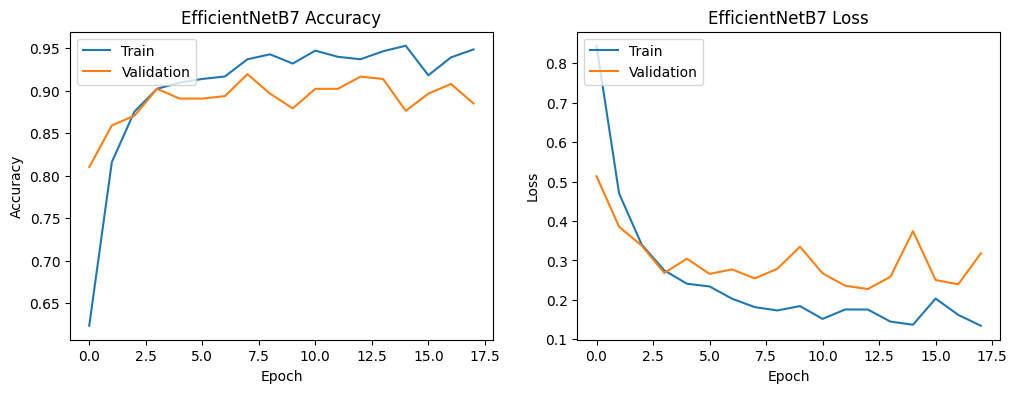

80/80 [==============================] - 41s 511ms/step - loss: 1.4371 - accuracy: 0.7090
Test Accuracy: 0.7090
80/80 [==============================] - 44s 504ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.90      0.80      0.85      1645
        rust       1.00      0.00      0.01       275
        scab       0.45      0.78      0.57       630

    accuracy                           0.71      2550
   macro avg       0.78      0.53      0.48      2550
weighted avg       0.80      0.71      0.69      2550



In [64]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_not_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(EN_B7, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B7, test_loss, test_acc, training_duration, results_not_trainable)

# Trainable

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.4639 - accuracy: 0.3994

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 31s 487ms/step - loss: 1.4639 - accuracy: 0.3994 - val_loss: 1.0540 - val_accuracy: 0.4626
Epoch 2/50
44/44 [==============================] - 21s 469ms/step - loss: 1.2851 - accuracy: 0.4551 - val_loss: 0.9785 - val_accuracy: 0.5460
Epoch 3/50
44/44 [==============================] - 21s 466ms/step - loss: 1.0967 - accuracy: 0.5398 - val_loss: 0.8939 - val_accuracy: 0.6466
Epoch 4/50
44/44 [==============================] - 21s 476ms/step - loss: 0.9653 - accuracy: 0.5745 - val_loss: 0.8077 - val_accuracy: 0.6925
Epoch 5/50
44/44 [==============================] - 22s 496ms/step - loss: 0.9666 - accuracy: 0.5991 - val_loss: 0.7317 - val_accuracy: 0.7241
Epoch 6/50
44/44 [==============================] - 22s 494ms/step - loss: 0.8471 - accuracy: 0.6520 - val_loss: 0.6710 - val_accuracy: 0.7529
Epoch 7/50
44/44 [==============================] - 21s 474ms/step - loss: 0.8063 - accuracy: 0.6679 - val_loss: 0.6260 - val_accuracy: 0.7586
Epoch 8/50

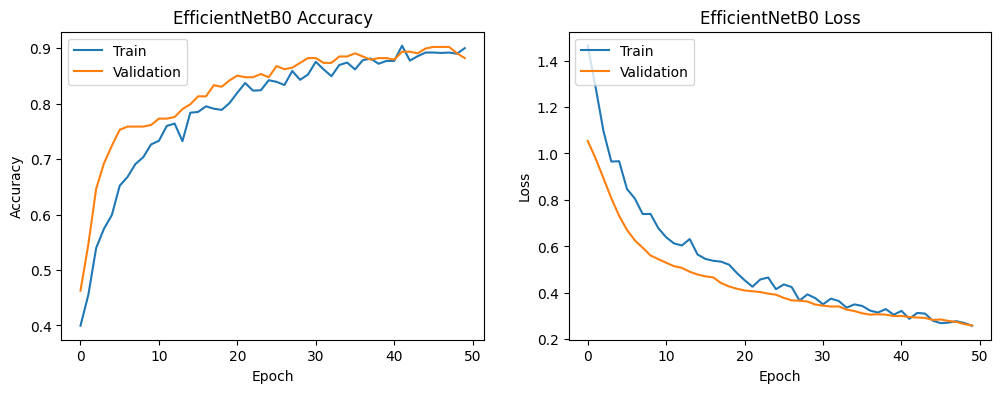

80/80 [==============================] - 2s 30ms/step - loss: 0.9537 - accuracy: 0.7169
Test Accuracy: 0.7169
80/80 [==============================] - 4s 28ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      0.96      0.83      1645
        rust       0.70      0.36      0.47       275
        scab       0.58      0.25      0.35       630

    accuracy                           0.72      2550
   macro avg       0.67      0.52      0.55      2550
weighted avg       0.69      0.72      0.67      2550



In [65]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(EN_B0, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B0, test_loss, training_duration, test_acc, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.6049 - accuracy: 0.3611

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 37s 574ms/step - loss: 1.6049 - accuracy: 0.3611 - val_loss: 1.0749 - val_accuracy: 0.4138
Epoch 2/50
44/44 [==============================] - 23s 519ms/step - loss: 1.3147 - accuracy: 0.4682 - val_loss: 0.9834 - val_accuracy: 0.4943
Epoch 3/50
44/44 [==============================] - 22s 509ms/step - loss: 1.1597 - accuracy: 0.5333 - val_loss: 0.8863 - val_accuracy: 0.6264
Epoch 4/50
44/44 [==============================] - 23s 515ms/step - loss: 1.0485 - accuracy: 0.5818 - val_loss: 0.7938 - val_accuracy: 0.6724
Epoch 5/50
44/44 [==============================] - 22s 497ms/step - loss: 0.9077 - accuracy: 0.6266 - val_loss: 0.7102 - val_accuracy: 0.7155
Epoch 6/50
44/44 [==============================] - 23s 532ms/step - loss: 0.8187 - accuracy: 0.6751 - val_loss: 0.6302 - val_accuracy: 0.7615
Epoch 7/50
44/44 [==============================] - 23s 514ms/step - loss: 0.7986 - accuracy: 0.6889 - val_loss: 0.5966 - val_accuracy: 0.7759
Epoch 8/50

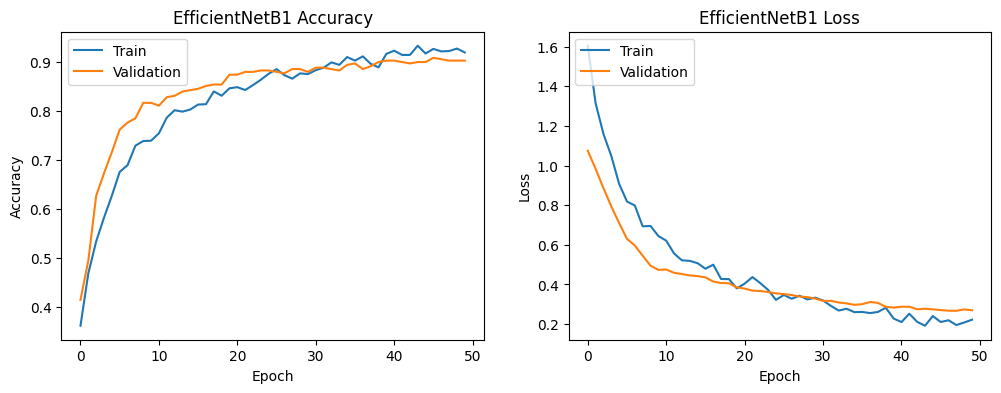

80/80 [==============================] - 3s 37ms/step - loss: 0.9520 - accuracy: 0.7106
Test Accuracy: 0.7106
80/80 [==============================] - 5s 34ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.79      0.85      0.82      1645
        rust       0.82      0.13      0.23       275
        scab       0.52      0.61      0.56       630

    accuracy                           0.71      2550
   macro avg       0.71      0.53      0.53      2550
weighted avg       0.72      0.71      0.69      2550



In [66]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1, test_loss, test_acc, training_duration = train_and_plot(EN_B1, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B1, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.4731 - accuracy: 0.4074

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 38s 571ms/step - loss: 1.4731 - accuracy: 0.4074 - val_loss: 1.0681 - val_accuracy: 0.4109
Epoch 2/50
44/44 [==============================] - 24s 557ms/step - loss: 1.2389 - accuracy: 0.4920 - val_loss: 1.0165 - val_accuracy: 0.4483
Epoch 3/50
44/44 [==============================] - 24s 539ms/step - loss: 1.0362 - accuracy: 0.5724 - val_loss: 0.9589 - val_accuracy: 0.4856
Epoch 4/50
44/44 [==============================] - 24s 550ms/step - loss: 0.9488 - accuracy: 0.6114 - val_loss: 0.8833 - val_accuracy: 0.5402
Epoch 5/50
44/44 [==============================] - 25s 558ms/step - loss: 0.8879 - accuracy: 0.6505 - val_loss: 0.8134 - val_accuracy: 0.5862
Epoch 6/50
44/44 [==============================] - 25s 561ms/step - loss: 0.8109 - accuracy: 0.6751 - val_loss: 0.7425 - val_accuracy: 0.6379
Epoch 7/50
44/44 [==============================] - 26s 587ms/step - loss: 0.7018 - accuracy: 0.7185 - val_loss: 0.6860 - val_accuracy: 0.6782
Epoch 8/50

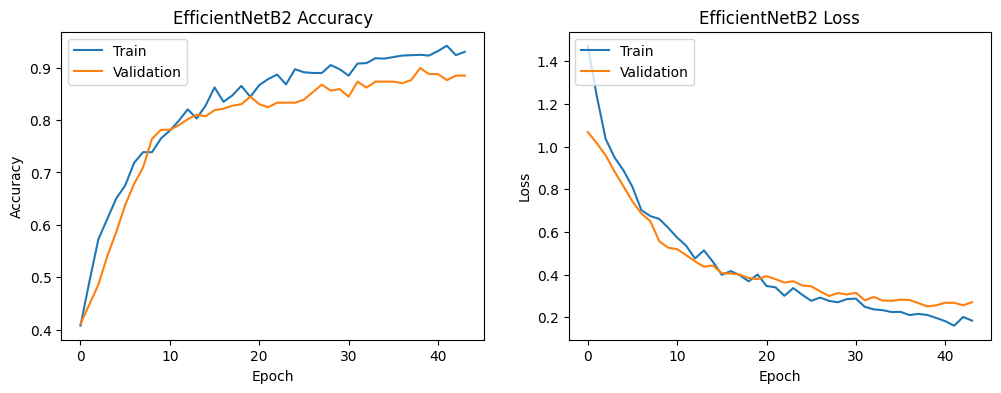

80/80 [==============================] - 2s 29ms/step - loss: 0.7639 - accuracy: 0.7271
Test Accuracy: 0.7271
80/80 [==============================] - 4s 26ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      0.85      0.85      1645
        rust       0.79      0.31      0.44       275
        scab       0.46      0.59      0.52       630

    accuracy                           0.73      2550
   macro avg       0.70      0.58      0.60      2550
weighted avg       0.75      0.73      0.72      2550



In [67]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2, test_loss, test_acc, training_duration = train_and_plot(EN_B2, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B2, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.5137 - accuracy: 0.3835

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 50s 802ms/step - loss: 1.5137 - accuracy: 0.3835 - val_loss: 1.0276 - val_accuracy: 0.4684
Epoch 2/50
44/44 [==============================] - 30s 690ms/step - loss: 1.1943 - accuracy: 0.5087 - val_loss: 0.9437 - val_accuracy: 0.5718
Epoch 3/50
44/44 [==============================] - 28s 646ms/step - loss: 0.9987 - accuracy: 0.5970 - val_loss: 0.8539 - val_accuracy: 0.6580
Epoch 4/50
44/44 [==============================] - 29s 667ms/step - loss: 0.8178 - accuracy: 0.6635 - val_loss: 0.7369 - val_accuracy: 0.7529
Epoch 5/50
44/44 [==============================] - 30s 686ms/step - loss: 0.7398 - accuracy: 0.6932 - val_loss: 0.6298 - val_accuracy: 0.7931
Epoch 6/50
44/44 [==============================] - 32s 724ms/step - loss: 0.6537 - accuracy: 0.7352 - val_loss: 0.5417 - val_accuracy: 0.8333
Epoch 7/50
44/44 [==============================] - 30s 688ms/step - loss: 0.6164 - accuracy: 0.7453 - val_loss: 0.4683 - val_accuracy: 0.8477
Epoch 8/50

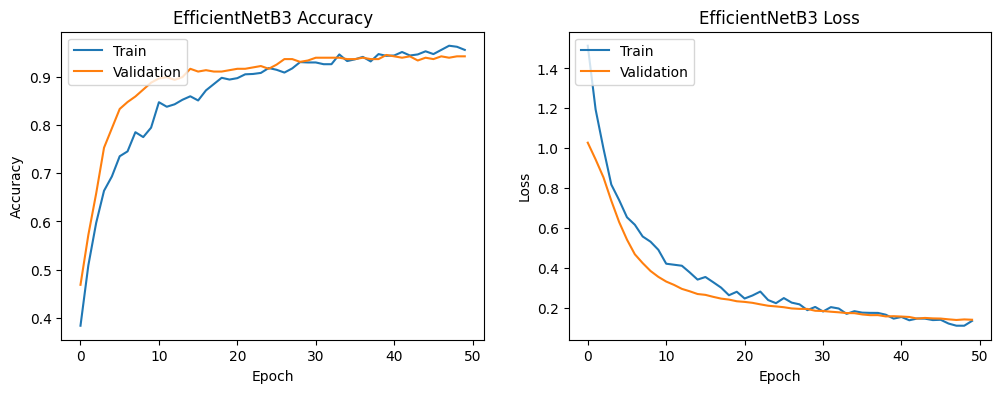

80/80 [==============================] - 6s 78ms/step - loss: 0.4136 - accuracy: 0.8404
Test Accuracy: 0.8404
80/80 [==============================] - 7s 61ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.92      0.91      0.92      1645
        rust       0.91      0.50      0.65       275
        scab       0.65      0.80      0.72       630

    accuracy                           0.84      2550
   macro avg       0.83      0.74      0.76      2550
weighted avg       0.86      0.84      0.84      2550



In [68]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3, test_loss, test_acc, training_duration = train_and_plot(EN_B3, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B3, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.3260 - accuracy: 0.4674

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 60s 984ms/step - loss: 1.3260 - accuracy: 0.4674 - val_loss: 0.9662 - val_accuracy: 0.6494
Epoch 2/50
44/44 [==============================] - 40s 919ms/step - loss: 0.9337 - accuracy: 0.6223 - val_loss: 0.8398 - val_accuracy: 0.7184
Epoch 3/50
44/44 [==============================] - 41s 928ms/step - loss: 0.7316 - accuracy: 0.6954 - val_loss: 0.7168 - val_accuracy: 0.7500
Epoch 4/50
44/44 [==============================] - 41s 941ms/step - loss: 0.6413 - accuracy: 0.7504 - val_loss: 0.6027 - val_accuracy: 0.7874
Epoch 5/50
44/44 [==============================] - 41s 939ms/step - loss: 0.5285 - accuracy: 0.7974 - val_loss: 0.4983 - val_accuracy: 0.8506
Epoch 6/50
44/44 [==============================] - 40s 919ms/step - loss: 0.4674 - accuracy: 0.8249 - val_loss: 0.4072 - val_accuracy: 0.8793
Epoch 7/50
44/44 [==============================] - 41s 931ms/step - loss: 0.4064 - accuracy: 0.8423 - val_loss: 0.3370 - val_accuracy: 0.8879
Epoch 8/50

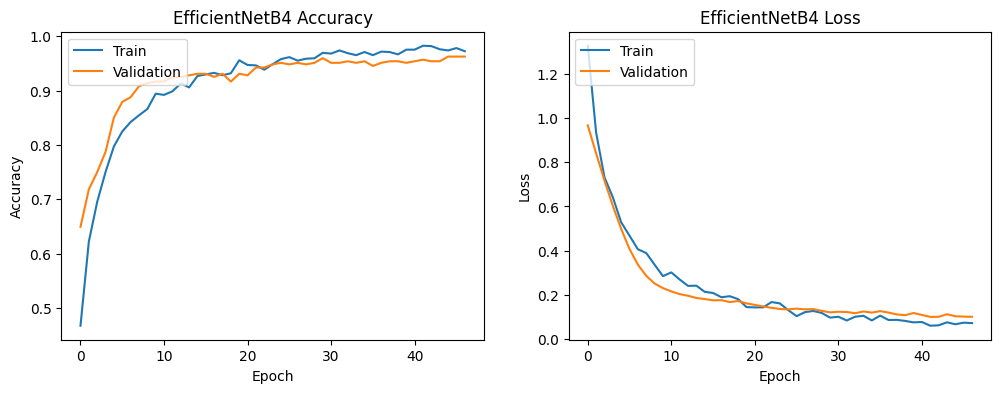

80/80 [==============================] - 11s 130ms/step - loss: 0.7957 - accuracy: 0.8063
Test Accuracy: 0.8063
80/80 [==============================] - 13s 132ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      0.99      0.92      1645
        rust       0.91      0.18      0.30       275
        scab       0.64      0.60      0.62       630

    accuracy                           0.81      2550
   macro avg       0.80      0.59      0.61      2550
weighted avg       0.81      0.81      0.78      2550



In [69]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4, test_loss, test_acc, training_duration = train_and_plot(EN_B4, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B4, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.4966 - accuracy: 0.4204

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 74s 1s/step - loss: 1.4966 - accuracy: 0.4204 - val_loss: 1.0452 - val_accuracy: 0.4684
Epoch 2/50
44/44 [==============================] - 56s 1s/step - loss: 1.0214 - accuracy: 0.5876 - val_loss: 0.9401 - val_accuracy: 0.6351
Epoch 3/50
44/44 [==============================] - 54s 1s/step - loss: 0.7290 - accuracy: 0.7012 - val_loss: 0.8250 - val_accuracy: 0.6954
Epoch 4/50
44/44 [==============================] - 53s 1s/step - loss: 0.5965 - accuracy: 0.7692 - val_loss: 0.7048 - val_accuracy: 0.7414
Epoch 5/50
44/44 [==============================] - 53s 1s/step - loss: 0.5245 - accuracy: 0.8082 - val_loss: 0.5901 - val_accuracy: 0.8075
Epoch 6/50
44/44 [==============================] - 54s 1s/step - loss: 0.4318 - accuracy: 0.8444 - val_loss: 0.4887 - val_accuracy: 0.8477
Epoch 7/50
44/44 [==============================] - 53s 1s/step - loss: 0.3684 - accuracy: 0.8632 - val_loss: 0.3981 - val_accuracy: 0.8707
Epoch 8/50
44/44 [=============

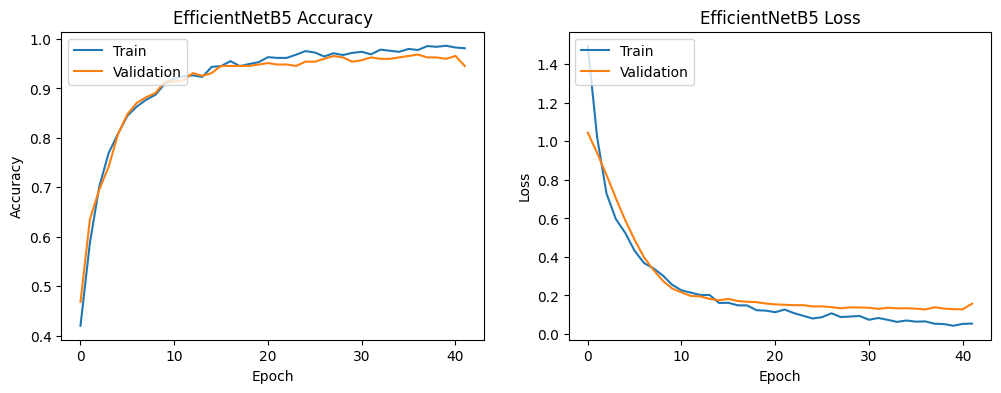

80/80 [==============================] - 15s 183ms/step - loss: 0.8640 - accuracy: 0.7784
Test Accuracy: 0.7784
80/80 [==============================] - 17s 175ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.92      0.90      0.91      1645
        rust       0.53      0.03      0.06       275
        scab       0.54      0.80      0.64       630

    accuracy                           0.78      2550
   macro avg       0.66      0.57      0.54      2550
weighted avg       0.78      0.78      0.75      2550



In [70]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5, test_loss, test_acc, training_duration = train_and_plot(EN_B5, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B5, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.5155 - accuracy: 0.3864

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 92s 2s/step - loss: 1.5155 - accuracy: 0.3864 - val_loss: 1.0874 - val_accuracy: 0.3534
Epoch 2/50
44/44 [==============================] - 67s 2s/step - loss: 0.9951 - accuracy: 0.5789 - val_loss: 1.0004 - val_accuracy: 0.5805
Epoch 3/50
44/44 [==============================] - 68s 2s/step - loss: 0.7183 - accuracy: 0.7033 - val_loss: 0.8851 - val_accuracy: 0.6983
Epoch 4/50
44/44 [==============================] - 68s 2s/step - loss: 0.5570 - accuracy: 0.7793 - val_loss: 0.7426 - val_accuracy: 0.7730
Epoch 5/50
44/44 [==============================] - 70s 2s/step - loss: 0.4362 - accuracy: 0.8242 - val_loss: 0.5898 - val_accuracy: 0.8276
Epoch 6/50
44/44 [==============================] - 69s 2s/step - loss: 0.3404 - accuracy: 0.8712 - val_loss: 0.4694 - val_accuracy: 0.8793
Epoch 7/50
44/44 [==============================] - 67s 2s/step - loss: 0.2811 - accuracy: 0.8958 - val_loss: 0.3670 - val_accuracy: 0.9023
Epoch 8/50
44/44 [=============

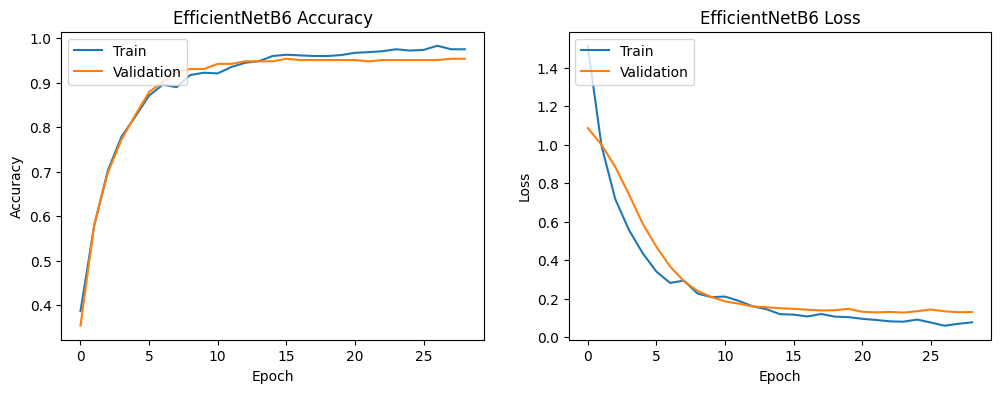

80/80 [==============================] - 24s 303ms/step - loss: 0.8718 - accuracy: 0.7463
Test Accuracy: 0.7463
80/80 [==============================] - 27s 297ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.75      1.00      0.86      1645
        rust       0.95      0.07      0.13       275
        scab       0.71      0.38      0.49       630

    accuracy                           0.75      2550
   macro avg       0.80      0.48      0.49      2550
weighted avg       0.76      0.75      0.69      2550



In [71]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6, test_loss, test_acc, training_duration = train_and_plot(EN_B6, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B6, test_loss, test_acc, training_duration, results_trainable)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.2828 - accuracy: 0.4711

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 112s 2s/step - loss: 1.2828 - accuracy: 0.4711 - val_loss: 1.0280 - val_accuracy: 0.4310
Epoch 2/50
44/44 [==============================] - 85s 2s/step - loss: 0.7454 - accuracy: 0.6968 - val_loss: 0.9234 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 84s 2s/step - loss: 0.5363 - accuracy: 0.7931 - val_loss: 0.7904 - val_accuracy: 0.6408
Epoch 4/50
44/44 [==============================] - 88s 2s/step - loss: 0.3668 - accuracy: 0.8625 - val_loss: 0.6501 - val_accuracy: 0.7385
Epoch 5/50
44/44 [==============================] - 84s 2s/step - loss: 0.3099 - accuracy: 0.8900 - val_loss: 0.5139 - val_accuracy: 0.8161
Epoch 6/50
44/44 [==============================] - 86s 2s/step - loss: 0.2425 - accuracy: 0.9117 - val_loss: 0.3831 - val_accuracy: 0.8736
Epoch 7/50
44/44 [==============================] - 84s 2s/step - loss: 0.2098 - accuracy: 0.9255 - val_loss: 0.2882 - val_accuracy: 0.8966
Epoch 8/50
44/44 [============

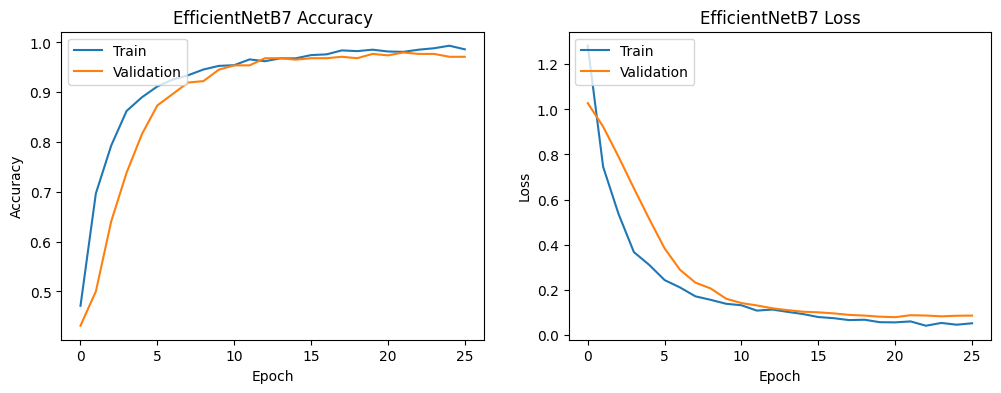

80/80 [==============================] - 41s 512ms/step - loss: 0.7640 - accuracy: 0.8184
Test Accuracy: 0.8184
80/80 [==============================] - 44s 509ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.95      0.92      0.94      1645
        rust       0.73      0.07      0.13       275
        scab       0.59      0.87      0.71       630

    accuracy                           0.82      2550
   macro avg       0.76      0.62      0.59      2550
weighted avg       0.84      0.82      0.79      2550



In [72]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(EN_B7, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B7, test_loss, test_acc, training_duration, results_trainable)

# Kesimpulan

In [73]:
results_df = pd.DataFrame(results_not_trainable)
print("\nHasil Evaluasi Model:\n", results_df[['Model','Train Accuracy','Validation Accuracy','Test Accuracy','Training Duration','Total Epoch']])
results_df.to_csv('outputs/results_not_trainable.csv', index=False)


Hasil Evaluasi Model:
             Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0  EfficientNetB0        0.923300             0.887931       0.716471   
1  EfficientNetB1        0.917511             0.882184       0.759216   
2  EfficientNetB2        0.897974             0.890805       0.745882   
3  EfficientNetB3        0.926917             0.933908       0.776078   
4  EfficientNetB4        0.938495             0.931035       0.732549   
5  EfficientNetB5        0.958032             0.936782       0.797647   
6  EfficientNetB6        0.965268             0.942529       0.754118   
7  EfficientNetB7        0.952967             0.919540       0.709020   

   Training Duration  Total Epoch  
0        1526.488535           18  
1        1526.488535           18  
2        1526.488535           18  
3        1526.488535           18  
4        1526.488535           18  
5        1526.488535           18  
6        1526.488535           18  
7        1526.488535          

In [74]:
results_df = pd.DataFrame(results_trainable)
print("\nHasil Evaluasi Model:\n", results_df[['Model','Train Accuracy','Validation Accuracy','Test Accuracy','Training Duration','Total Epoch']])
results_df.to_csv('outputs/results_trainable.csv', index=False)


Hasil Evaluasi Model:
             Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0  EfficientNetB0        0.904486             0.902299    1056.849794   
1  EfficientNetB1        0.932706             0.908046       0.710588   
2  EfficientNetB2        0.942113             0.899425       0.727059   
3  EfficientNetB3        0.964544             0.945402       0.840392   
4  EfficientNetB4        0.982634             0.962644       0.806275   
5  EfficientNetB5        0.986252             0.968391       0.778431   
6  EfficientNetB6        0.983357             0.954023       0.746275   
7  EfficientNetB7        0.993488             0.979885       0.818431   

   Training Duration  Total Epoch  
0        2206.455527           26  
1        2206.455527           26  
2        2206.455527           26  
3        2206.455527           26  
4        2206.455527           26  
5        2206.455527           26  
6        2206.455527           26  
7        2206.455527          